In [1]:
import os
import sys
sys.path.append(".")

import numpy as np
import torch
from torch.utils import data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import PIL

import json
import yaml
from dataclasses import dataclass
import pyrallis
from tqdm import tqdm
from omegaconf import OmegaConf
from pathlib import Path
from natsort import natsorted
from einops import rearrange

from pytorch_lightning import seed_everything
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler
from dataloader import dataset_factory
from dataloader.cityscapes import CityscapesBaseInfo
from dataloader.custom_transform import *

In [2]:
H, W = 512, 1024
label_color_map = CityscapesBaseInfo().create_label_colormap(version='ade20k')

# 0. Helpers

In [3]:
with open('./dataloader/cityscapes_info.json', 'r') as fr:
    labels_info = json.load(fr)
lb_map = {el['id']: el['trainId'] for el in labels_info}

def convert_labels(label):
    for k, v in lb_map.items():
        label[label == k] = v
    return label

def read_label(label_path):
    label = Image.open(label_path)
    label = label.resize((W, H), PIL.Image.NEAREST)
    label = np.array(label).astype(np.int64)  
    label = convert_labels(label)    
    label = torch.LongTensor(label)
    return label

def label_encode_color(label):
    # encode the mask using color coding
    # return label: Tensor [3,h,w], (-1,1)
    label_ = np.copy(label)
    label_[label_ == 255] = 19
    label_ = label_color_map[label_]
    return label_

def label_encode_id(label):
    # return label: Tensor [1,h,w]
    label_ = np.copy(label)
    label_[label_ == 255] = 19
    label_ = torch.from_numpy(label_)
    label_ = label_.unsqueeze(0)
    return label_

def convert_id_to_control(label_id, model):
    control = model.class_embedding_manager(label_id.unsqueeze(0))  # [bs, c, h, w]
    control = control.to(model.device)
    control = control.squeeze(0)
    return control

# 1. Load Model

In [4]:
# Cityscapes
model_config = 'models/cldm_seg_cityscapes_multi_step_D.yaml'
checkpoint_dir = 'checkpoint/cityscapes_step9.ckpt'
segmenter_config = None
model = create_model(model_config,extra_segmenter_config=segmenter_config).cpu()

model.load_state_dict(load_state_dict(checkpoint_dir, location='cpu'), strict=False) 
model = model.cuda()
ddim_sampler = DDIMSampler(model)

if hasattr(model, 'model_attend'):
    model.model_attend.image_ratio = W / H
    model.model_attend.attention_store.image_ratio = W / H

No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at /fs/scratch/rng_cr_bcai_dl/lyu7rng/0_project_large_models/pretrained/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.20.layer_norm1.weight', 'vision_model.encoder.layers.9.self_attn.q_proj.bias', 'vision_model.encoder.layers.22.self_attn.q_proj.bias', 'vision_model.encoder.layers.5.self_attn.v_proj.bias', 'vision_model.encoder.layers.4.self_attn.v_proj.weight', 'vision_model.encoder.layers.12.mlp.fc2.bias', 'vision_model.encoder.layers.8.self_attn.q_proj.weight', 'vision_model.encoder.layers.19.mlp.fc1.weight', 'vision_model.encoder.layers.7.layer_norm2.bias', 'vision_model.encoder.layers.17.self_attn.v_proj.bias', 'vision_model.encoder.layers.21.layer_norm1.weight', 'vision_model.encoder.layers.12.layer_norm2.weight', 'vision_model.encoder.layers.13.self_attn.out_proj.bias', 'vision_model.encoder.layers.23.self_attn.q_proj.weight', 'vision_model.encoder.layers.13.self_attn.v_proj.weight', 'visi

Loading weights for net_encoder
Loading weights for net_decoder
Loaded model config from [models/cldm_seg_cityscapes_multi_step_D.yaml]
Loaded state_dict from [../ALDM_checkpoints/cityscapes_step9.ckpt]


# 2. Read & Visualize Input Layout

In [5]:
test_label_path = 'test_image/frankfurt_000000_000576_gtFine_labelIds.png'

In [6]:
label = read_label(test_label_path)
label_color = label_encode_color(label)           # (512, 1024, 3)
label_id = label_encode_id(label)                 # (1, 512, 1024)
control_cond = convert_id_to_control(label_id, model)  # (768, 128, 256)

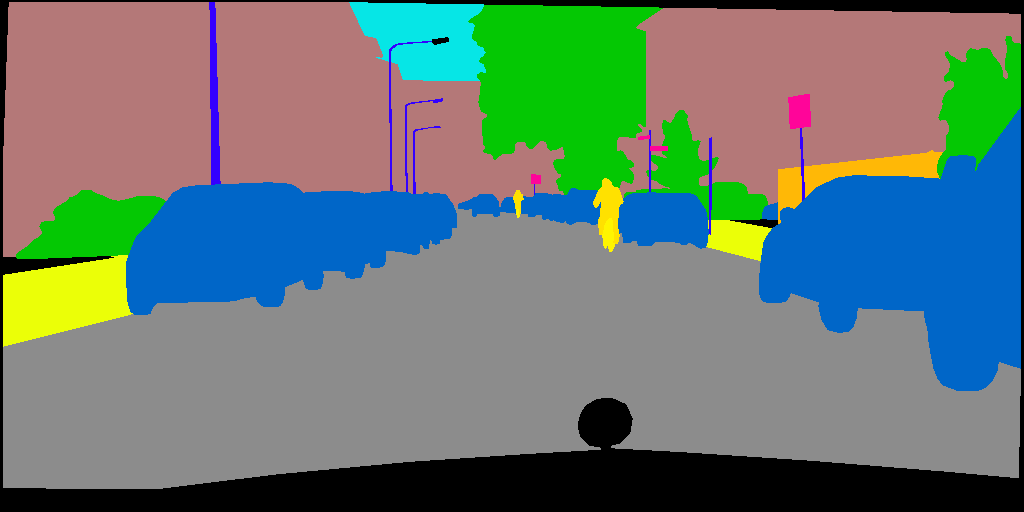

In [7]:
# Visualize the input layout
label_color_pil = Image.fromarray(np.uint8(label_color))
display(label_color_pil)

# 3. Generate!

In [8]:
# Define the prompt here
prompt = 'snowy scene'

# # Define the negative prompt here
n_prompt = ''

num_samples = 1
ddim_steps = 25
cfg_scale = 7.5
seed = 23

In [9]:
control = torch.stack([control_cond for _ in range(num_samples)], dim=0)
control = control.clone().cuda()

cond = {"c_concat": [control], 
        "c_crossattn": [model.get_learned_conditioning([prompt] * num_samples)]}
un_cond = {"c_concat": [control], 
           "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
shape = (4, H // 8, W // 8)
seed_everything(seed)
samples, intermediates = ddim_sampler.sample(
    ddim_steps, num_samples,
    shape, cond, verbose=False, eta=0.0,
    unconditional_guidance_scale=cfg_scale,
    unconditional_conditioning=un_cond
)
        
x_samples = model.decode_first_stage(samples)
x_samples = (rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

Global seed set to 23


Data shape for DDIM sampling is (1, 4, 64, 128), eta 0.0
Running DDIM Sampling with 25 timesteps


DDIM Sampler: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


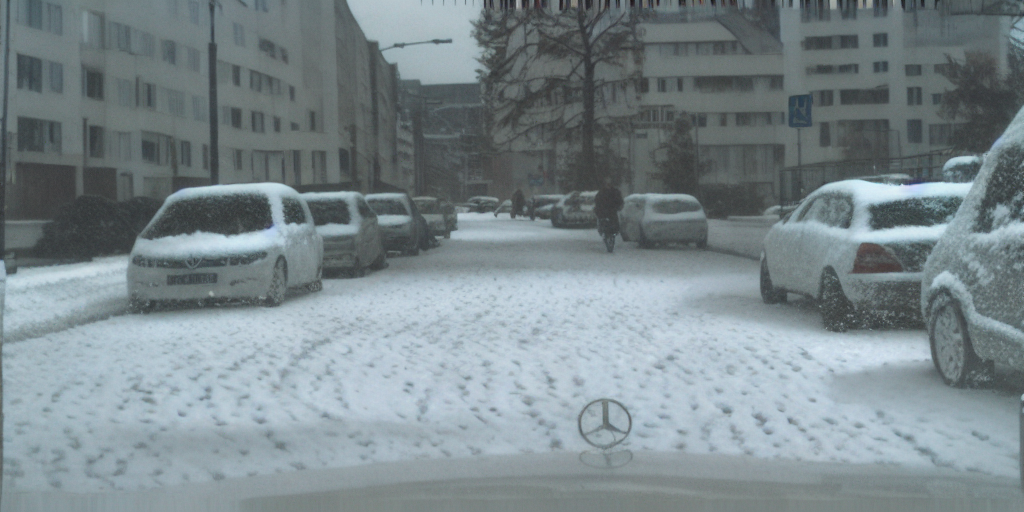

In [10]:
for sample in x_samples:
    sample_pil = Image.fromarray(sample)
    display(sample_pil)

In [11]:
sample_pil.save(f'test_image/test_output_{seed}.png')